# Network HPM "table"
adapted from https://github.com/DifferentiableUniverseInitiative/Baryonator/blob/main/notebooks/HPM_test_on_CAMELS.ipynb
Implement the mapping from local density and scalar force to pressure and temperature (see https://arxiv.org/abs/2107.04606) as a neural network that learns the mean response.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, tqdm, glob
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.49'
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax
from flax import nnx
import orbax.checkpoint as ocp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.utils import power_spectrum
from jaxpm.utils import _initialize_pk
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel, invnabla_kernel
from jaxpm.nn import MLP
from jaxpm import camels

jax.devices("gpu")

[cuda(id=0)]

In [3]:
# This will define the mesh size we use to make 3d density maps 
# Note that the physical size of the volume is 25 Mpc/h on the side
# so one voxel is 25/128 Mpc/h on the side
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3
box_size = [float(mesh_per_dim)] * 3

## Loading the snapshots

In [4]:
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0"

out_dict = camels.load_CV_camels_hydro(
    SIM,
    mesh_per_dim,
    parts_per_dim,
    # i_snapshots=range(-5, 0),
)

scales = out_dict["scales"]
masses = out_dict["masses"]

dm_poss = out_dict["dm_poss"]

gas_poss = out_dict["gas_poss"]
gas_masss = out_dict["gas_masss"]
gas_rhos = out_dict["gas_rhos"]
gas_Ts = out_dict["gas_Ts"]
gas_Ps = out_dict["gas_Ps"]

finding unique gas particle indices: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]


Selecting 262144 dark matter (deterministic) and gas (random) particles


loading snapshots: 100%|██████████| 34/34 [04:45<00:00,  8.40s/it]


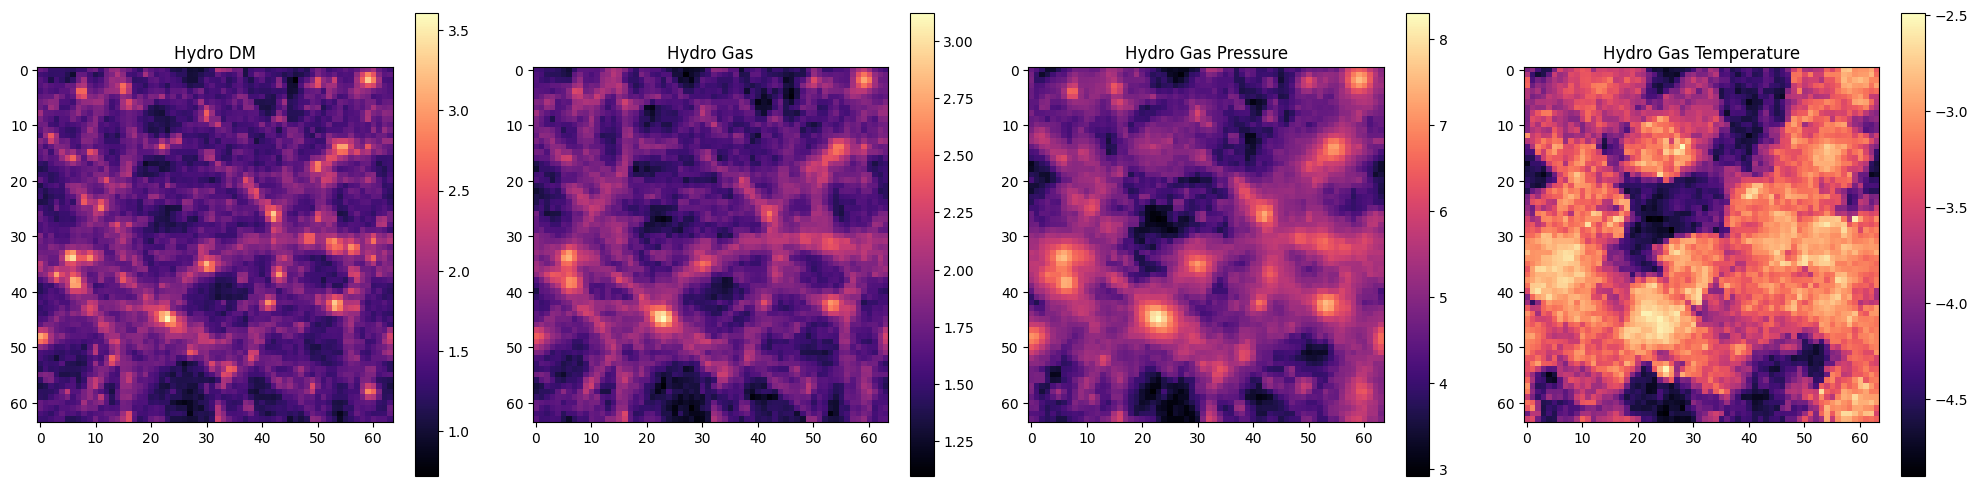

In [5]:
i = -1

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

im0 = ax[0].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), dm_poss[i]).sum(axis=0)), cmap='magma')
ax[0].set(title='Hydro DM')
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), gas_poss[i]).sum(axis=0)), cmap='magma')
ax[1].set(title='Hydro Gas')
fig.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), gas_poss[i], gas_Ps[i]/gas_rhos[i]).sum(axis=0)), cmap='magma')
ax[2].set(title='Hydro Gas Pressure')
fig.colorbar(im2, ax=ax[2])

im3 = ax[3].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), gas_poss[i], gas_Ts[i]/gas_rhos[i]).sum(axis=0)), cmap='magma')
ax[3].set(title='Hydro Gas Temperature')
fig.colorbar(im3, ax=ax[3])

fig.tight_layout()

## Testing correspondance between local environment and P/T

In [6]:
# vmap over the snapshots
vcic_paint = jax.vmap(cic_paint, in_axes=(None,0,0))
vcic_read = jax.vmap(cic_read, in_axes=(0,0))

# rho
rho_dm = vcic_paint(jnp.zeros(mesh_shape), dm_poss, None)
# TODO this is a per-particle weighting, unlike in the PM
rho_gas = vcic_paint(jnp.zeros(mesh_shape), gas_poss, gas_masss/masses[1])
# rho_gas = vcic_paint(jnp.zeros(mesh_shape), gas_poss, Omega_b/(Omega_m-Omega_b))
rho_tot = rho_dm + rho_gas

gas_rho = vcic_read(rho_tot, gas_poss)

# fscalar
kvec = fftk(mesh_shape)
delta_k = jax.vmap(jnp.fft.rfftn, in_axes=0)(rho_tot)
fscalar_tot = jax.vmap(jnp.fft.irfftn, in_axes=0)(delta_k * invnabla_kernel(kvec))
gas_fscalar = vcic_read(fscalar_tot, gas_poss)

In [7]:
X = jnp.stack(
    [
        jnp.tile(scales, (parts_per_dim**3, 1)).T, 
        np.log10(gas_rhos),
        np.arcsinh(gas_fscalar/100)
    ], 
    axis=-1
)
Y = jnp.stack(
    [
        np.log10(gas_Ps), 
        np.log10(gas_Ts)], 
    axis=-1
)

# standardizing doesn't have an effect on the MLP's performance
# X_scaler = StandardScaler()
# X_scaled = X_scaler.fit_transform(X)

# Y_scaler = StandardScaler()
# Y_scaled = Y_scaler.fit_transform(Y)

X_train = X.reshape(-1, X.shape[-1])
Y_train = Y.reshape(-1, Y.shape[-1])

# X_train = []
# X_test = []
# Y_train = []
# Y_test = []
# for i in range(len(scales):
#     train_test_split(X, Y, test_size=50_000, random_state=42)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=50_000, random_state=42)


# print(f"{X_train.shape[0]} training samples")
# print(f"{X_test.shape[0]} test samples")

In [8]:
model = MLP(X.shape[-1], Y.shape[-1], 512, 4, nnx.Rngs(0))

total_steps = 100_000
batch_size = 1024

lr_scheduler = optax.cosine_decay_schedule(init_value=1e-3, decay_steps=total_steps, alpha=0.0)
momentum = 0.9
adam = optax.adamw(lr_scheduler, momentum)

# training

### @nnx.jit

In [9]:
# optimizer = nnx.Optimizer(model, adam)

# @nnx.jit
# def train_step(model, optimizer, batch):
#     x, y = batch

#     def loss_fn(model):
#         y_pred = model(x)
#         return jnp.mean((y - y_pred) **2)
    
#     loss, grads = nnx.value_and_grad(loss_fn)(model)
#     optimizer.update(grads)

#     return loss

# losses = []
# for i in tqdm.tqdm(range(total_steps)):
#     inds = np.random.choice(X_train.shape[0], batch_size)
#     batch = (X_train[inds], Y_train[inds])
    
#     loss = train_step(model, optimizer, batch)
#     losses.append(loss)

# fig, ax = plt.subplots()
# ax.plot(losses[100:])
# ax.set(yscale="log")

### @jax.jit (with nnx.split)

100%|██████████| 100000/100000 [03:55<00:00, 424.45it/s]


[None]

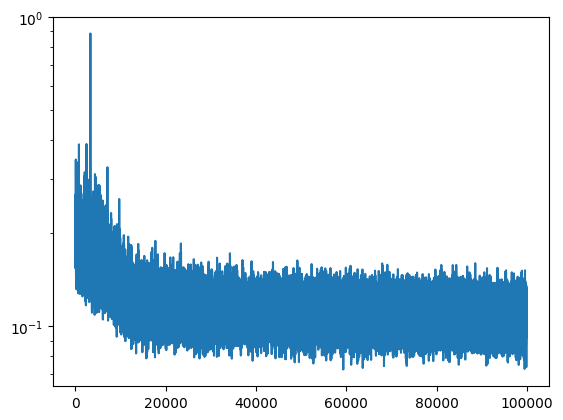

In [10]:
graphdef, params = nnx.split(model)
opt_state = adam.init(params)

@jax.jit
def train_step(params, opt_state, batch):
    x, y = batch

    def loss_fn(params):
        model = nnx.merge(graphdef, params)
        y_pred = model(x)
        loss = jnp.mean((y - y_pred) ** 2)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(params)

    updates, opt_state = adam.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

losses = []
for i in tqdm.tqdm(range(total_steps)):
    inds = np.random.choice(X_train.shape[0], batch_size)
    batch = (X_train[inds], Y_train[inds])
    
    params, opt_state, loss = train_step(params, opt_state, batch)
    losses.append(loss)

model = nnx.merge(graphdef, params)

fig, ax = plt.subplots()
ax.plot(losses[100:])
ax.set(yscale="log")

### checkpointing

In [11]:
# see https://flax.readthedocs.io/en/latest/guides/checkpointing.html
checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_mlp.jx")
checkpointer = ocp.StandardCheckpointer()

In [12]:
_, params = nnx.split(model)
checkpointer.save(checkpoint_file, params, force=True)

In [13]:
# abstract_model = nnx.eval_shape(lambda: model)
# graphdef, abstract_params = nnx.split(abstract_model)

# params = checkpointer.restore(checkpoint_file, abstract_params)
# model = nnx.merge(graphdef, params)

# testing

### scatter plots

In [14]:
i_scale = -1
X_test = X[i_scale, :50_000]
Y_test = Y[i_scale, :50_000]

preds = []
for i in tqdm.tqdm(range(X_test.shape[0]//batch_size)): 
    preds.append(model(X_test[i*batch_size:(i+1)*batch_size]))
preds.append(model(X_test[(i+1)*batch_size:]))
preds = jnp.concatenate(preds, axis=0)

100%|██████████| 48/48 [00:00<00:00, 127.94it/s]


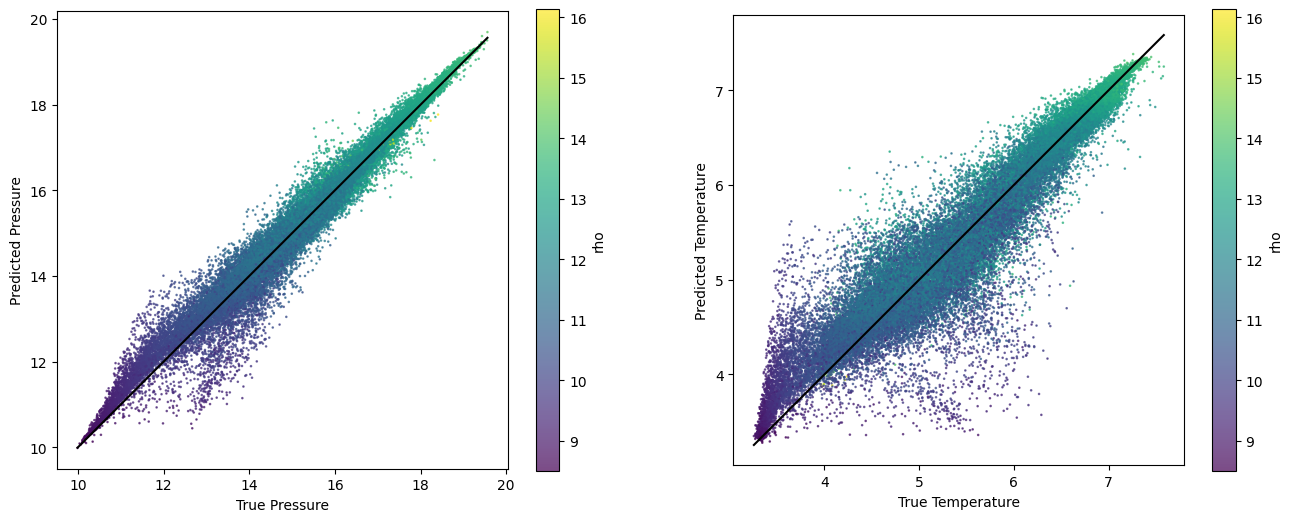

In [15]:
plt.figure(figsize=[16,6])

plt.subplot(121)
sc1 = plt.scatter(Y_test[:,0], preds[:,0], c=X_test[:,1], s=0.75, alpha=0.7)
plt.colorbar(sc1, label="rho")
plt.xlabel('True Pressure')
plt.ylabel('Predicted Pressure')
plt.plot([Y_test[:,0].min(), Y_test[:,0].max()], [Y_test[:,0].min(), Y_test[:,0].max()], color='k')
plt.gca().set_aspect('equal')

plt.subplot(122)
sc2 = plt.scatter(Y_test[:,1], preds[:,1], c=X_test[:,1], s=0.75, alpha=0.7)
plt.colorbar(sc2, label="rho")
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.plot([Y_test[:,1].min(), Y_test[:,1].max()], [Y_test[:,1].min(), Y_test[:,1].max()], color='k')
plt.gca().set_aspect('equal')

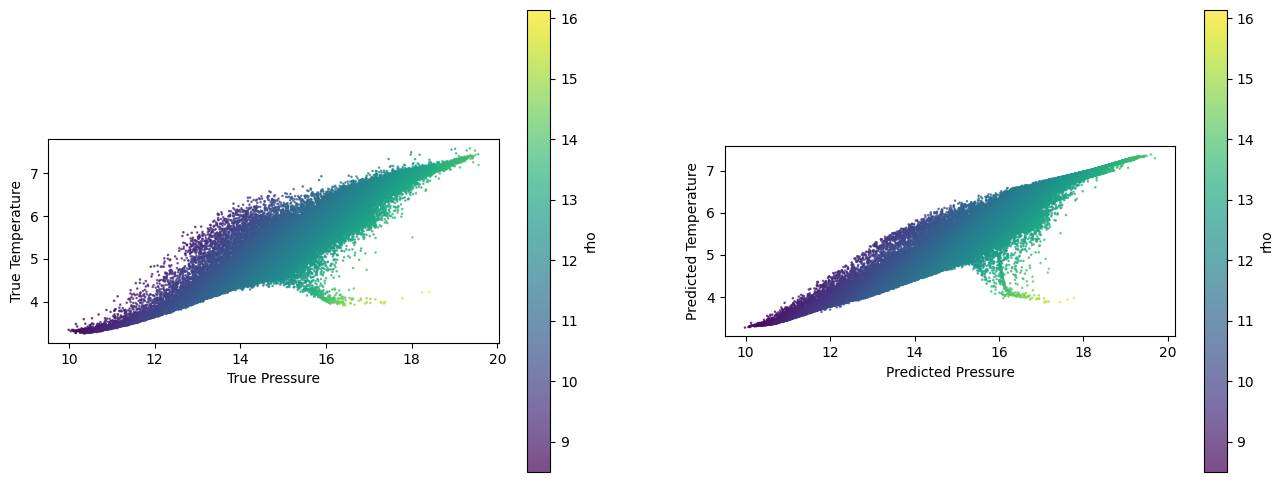

In [16]:
plt.figure(figsize=[16,6])

plt.subplot(121)
sc1 = plt.scatter(Y_test[:,0], Y_test[:,1], c=X_test[:,1], s=0.75, alpha=0.7)
plt.colorbar(sc1, label="rho")
plt.xlabel('True Pressure')
plt.ylabel('True Temperature')
plt.gca().set_aspect('equal')

plt.subplot(122)
sc2 = plt.scatter(preds[:,0], preds[:,1], c=X_test[:,1], s=0.75, alpha=0.7)
plt.colorbar(sc2, label="rho")
plt.xlabel('Predicted Pressure')
plt.ylabel('Predicted Temperature')
plt.gca().set_aspect('equal')

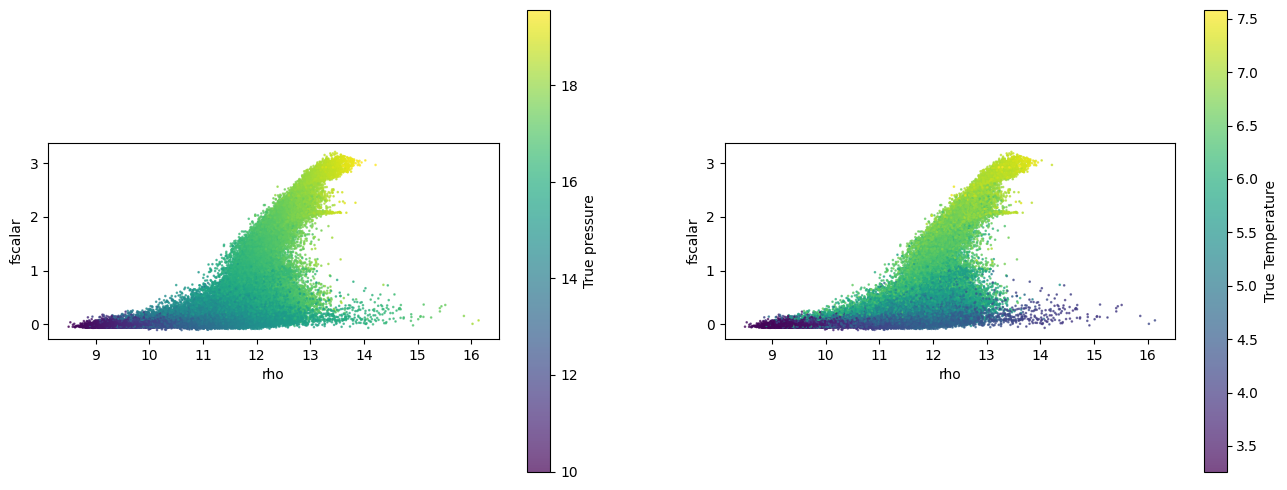

In [17]:
plt.figure(figsize=[16,6])

plt.subplot(121)
sc1 = plt.scatter(X_test[:,1], X_test[:,2], c=Y_test[:,0], s=0.75, alpha=0.7)
plt.colorbar(sc1, label="True pressure")
plt.xlabel('rho')
plt.ylabel('fscalar')
plt.gca().set_aspect('equal')

plt.subplot(122)
sc2 = plt.scatter(X_test[:,1], X_test[:,2], c=Y_test[:,1], s=0.75, alpha=0.7)
plt.colorbar(sc2, label="True Temperature")
plt.xlabel('rho')
plt.ylabel('fscalar')
plt.gca().set_aspect('equal')

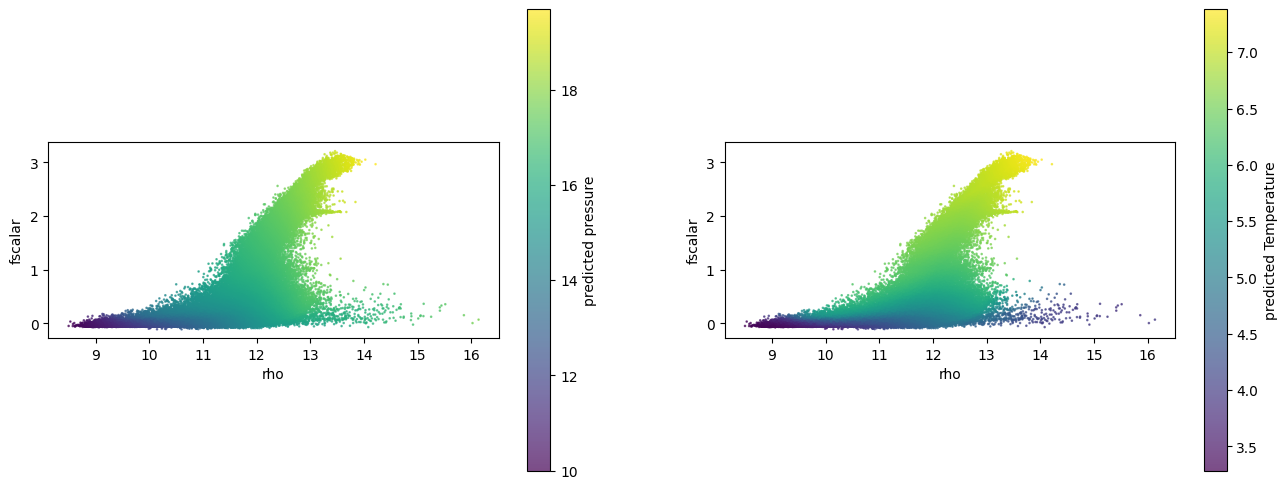

In [18]:
plt.figure(figsize=[16,6])

plt.subplot(121)
sc1 = plt.scatter(X_test[:,1], X_test[:,2], c=preds[:,0], s=0.75, alpha=0.7)
plt.colorbar(sc1, label="predicted pressure")
plt.xlabel('rho')
plt.ylabel('fscalar')
plt.gca().set_aspect('equal')

plt.subplot(122)
sc2 = plt.scatter(X_test[:,1], X_test[:,2], c=preds[:,1], s=0.75, alpha=0.7)
plt.colorbar(sc2, label="predicted Temperature")
plt.xlabel('rho')
plt.ylabel('fscalar')
plt.gca().set_aspect('equal')

### reconstruction of the simultions

In [19]:
# preds = []
# for i in tqdm.tqdm(range(X_scaled.shape[0]//batch_size)): 
#     preds.append(model(X_scaled[i*batch_size:(i+1)*batch_size]))
# preds.append(model(X_scaled[(i+1)*batch_size:]))
# preds = jnp.concatenate(preds, axis=0)

# # invert the normalization
# # preds = Y_scaler.inverse_transform(preds)

In [20]:
i_scale = -1

preds = []
for i in tqdm.tqdm(range(X.shape[1]//batch_size)): 
    preds.append(model(X[i_scale, i*batch_size:(i+1)*batch_size]))
preds.append(model(X[i_scale, (i+1)*batch_size:]))
preds = jnp.concatenate(preds, axis=0)

100%|██████████| 256/256 [00:01<00:00, 176.38it/s]


Text(0.5, 1.0, 'ML Table Gas Temperature')

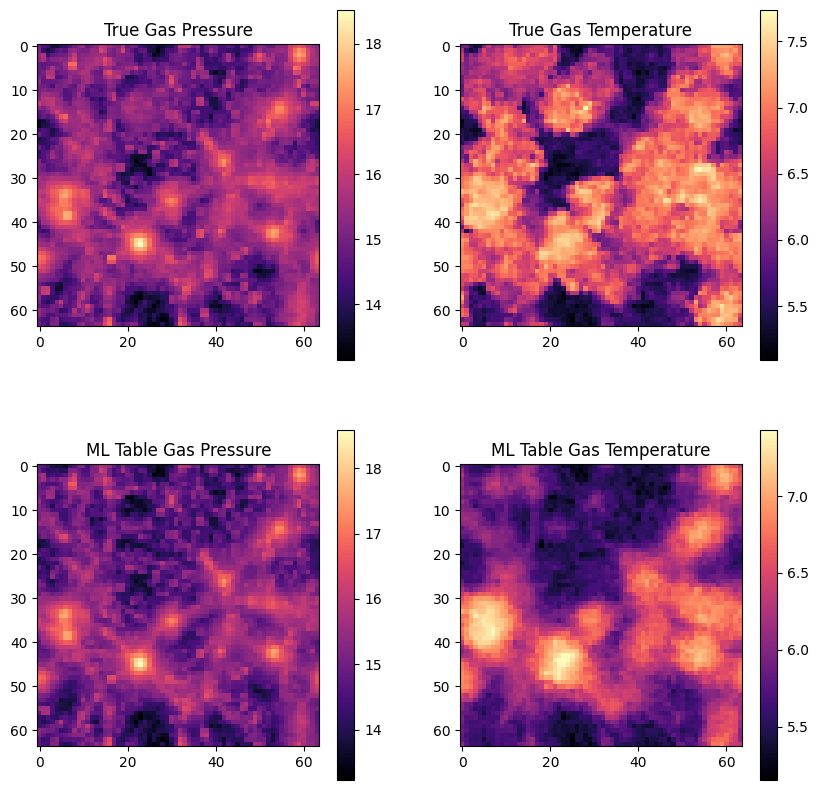

In [21]:
def paint_log_sum(positions, weights):
    return np.log10(cic_paint(jnp.zeros(mesh_shape), positions, weights).sum(axis=0))

plt.figure(figsize=[10,10])

plt.subplot(221)
im1 = plt.imshow(paint_log_sum(gas_poss[i_scale], gas_Ps[i_scale]/gas_rho[i_scale]), cmap='magma')
plt.colorbar(im1)
plt.title('True Gas Pressure')

plt.subplot(222)
im2 = plt.imshow(paint_log_sum(gas_poss[i_scale], gas_Ts[i_scale]/gas_rho[i_scale]), cmap='magma')
plt.colorbar(im2)
plt.title('True Gas Temperature')

plt.subplot(223)
im3 = plt.imshow(paint_log_sum(gas_poss[i_scale], 10**preds[:,0]/gas_rho[i_scale]), cmap='magma')
plt.colorbar(im3)
plt.title('ML Table Gas Pressure')

plt.subplot(224)
im4 = plt.imshow(paint_log_sum(gas_poss[i_scale], 10**preds[:,1]/gas_rho[i_scale]), cmap='magma')
plt.colorbar(im4)
plt.title('ML Table Gas Temperature')